# Homework 2
* Author: Kenji Oman ([github profile](https://github.com/kenjioman))
* Date: 8 March 2019

Original homework can be found [in the github reopo](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week02.pdf).  Questions copied here in line with the work to make it easier to follow.

In [1]:
# Make necessary imports
import numpy as np
import scipy.stats as sps
import pandas as pd
import pymc3 as pm
import theano
import patsy

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Problem 1
The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

| Individual | weight | expected height | 89% interval |
| --- | --- | --- | --- |
| 1 | 45 | |
| 2 | 40 | |
| 3 | 65 | |
| 4 | 31 | |
| 5 | 53 | |

In [2]:
# First, load the !Kung data
df = pd.read_csv('../Data/Howell1.csv', sep=';', header=0)
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
# Also, construct the individuals we wish to predict heights for
predict = pd.DataFrame([[1, 45], [2, 40], [3, 65], [4, 31], [5, 53]], columns=['individual', 'weight'])
predict.head()

,individual,weight
0,1,45
1,2,40
2,3,65
3,4,31
4,5,53


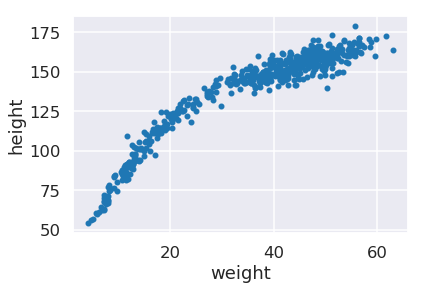

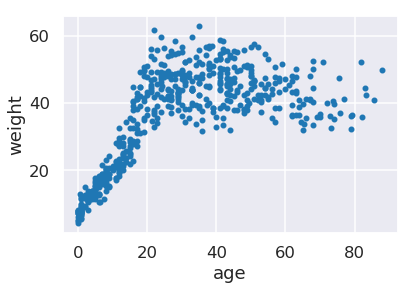

In [4]:
# First, take a look at what the data looks like
df.plot('weight', 'height', kind='scatter')
plt.show()

# And comparing weight with age
df.plot('age', 'weight', kind='scatter')
plt.show()

Taking a loook at the data above, it is definitely not linear across the full spectrum of ages and weights.  Let's try constraining the data to just adults (those aged 18 and over) and fit a linear model for our predictions.

In [5]:
# Get just the adults from the data
adult_df = df[df.age >= 17]

### Note, no quap in pymc3:
**Although the book uses** `quap` **(a quadratic or Laplace approximation) to find the posterior distribution, as best as I can tell, [this is not implemented as a part of _PyMC3_](https://docs.pymc.io/developer_guide.html#extending-pymc3)**.  Looking at what the PyMC3 devs did when they ported the code, I found a comment for [code box 4.26](https://render.githubusercontent.com/view/ipynb?commit=33358f2ce2419300404f409bddaeae314e151fcb&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f70796d632d646576732f7265736f75726365732f333333353866326365323431393330303430346634303962646461656165333134653135316663622f52657468696e6b696e672f4368705f30342e6970796e62&nwo=pymc-devs%2Fresources&path=Rethinking%2FChp_04.ipynb&repository_id=110546454&repository_type=Repository#Code-4.26) where they said they will just use a sampling method, since this is easily done in PyMC3.  Therefore, I will do the same.  This will likely lead to some small discrepancies between my solutions and the given solutions, but they should remain fairly consistent.

In [6]:
# Now, construct a model to fit the data, using the same model as used in 
np.random.seed(123) # Needed to get reproducability in the notebook
with pm.Model() as height_mdl:
    a = pm.Normal('a', mu=178, sd=20)
    b = pm.Lognormal('b', mu=0, sd=1)
    
    # Define our mu, based on the linear regression equation.  The commented out
    # version doesn't keep mu values in the trace, while the non-commented version does.
    mu = pm.Deterministic('mu', a + b*(adult_df.weight - adult_df.weight.mean()))
    #mu = a + b*(adult_df.weight - adult_df.weight.mean())
    
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    height = pm.Normal('height', mu, sigma, observed=adult_df.height)
    
    # This sets us up to automatically sample from the posterior distribution
    trace_1 = pm.sample(draws=1000, tune=1000, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]
100%|██████████| 2000/2000 [00:02<00:00, 803.58it/s]


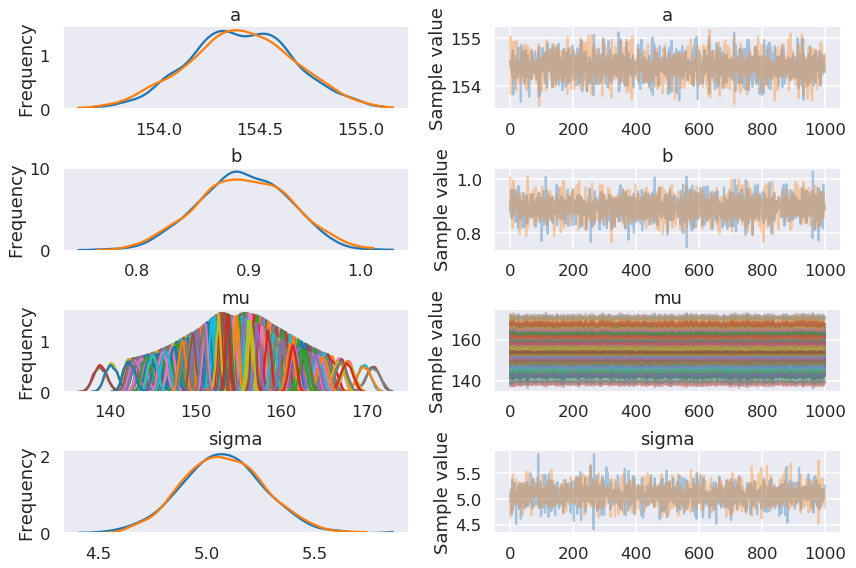

In [7]:
# Let's look at the trace, as they do in the getting started documentation:
# (https://docs.pymc.io/notebooks/getting_started.html#Posterior-analysis)
pm.traceplot(trace_1)
plt.show()

It looks like we have an average height of ~154.5 cm, with people having about 0.9 additional cm of height per kg of extra weight.  This seems reasonable, I suppose, although if we look back at the full height vs weight plot above, we notice that **the max weight** in the dataset is ~60 kg.  This is quite a bit lower than average, as [wikipedia lists the world average weight](https://en.wikipedia.org/wiki/Human_body_weight#By_region) at 62.2kg.

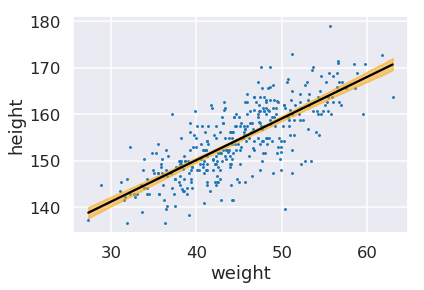

In [8]:
# Now, let's try plotting our predictions.
# First, the data
ax = adult_df.plot.scatter('weight', 'height', s=2)

# Now, add on the 89% MAP interval. First, need
# a range over which to calculate the MAPs
w_grid = np.linspace(adult_df.weight.min(), adult_df.weight.max(), num=1000)

# Now, for each point in our list of weights, we need to get predicted height values, using
# our full posterior distribution
height_pred = np.array([trace_1['a'] + trace_1['b'] * (w - adult_df.weight.mean()) for w in w_grid])

# Now, for each weight in our grid, calculate the heighest posterior density interval
height_hpd = pm.hpd(height_pred.T, alpha=0.11)

# Also, the mean value per weight
height_mean = height_pred.mean(axis=1)

# Now, plot the HPD interval
plt.fill_between(w_grid, height_hpd[:, 0], height_hpd[:, 1], color='orange', alpha=0.5)

# And finally, the predicted line
ax.plot(w_grid, height_mean, color='black')
plt.show()

Comparing with Figure 4.9, not too bad!  Now, let's try making the predictions for the specific values given in the problem.

In [9]:
# For our grid, we need to calculated predicted heights based on our full posterior distribution.
pred_height = np.array([trace_1['a'] + trace_1['b'] * (w - adult_df.weight.mean()) for w in predict.weight])

# Now, for each weight, calculate the 89% HPD
pred_height_hpd = pm.hpd(pred_height.T, alpha=0.11)

# Also, calculate the mean values for each of these weights
predict['predicted'] = pred_height.mean(axis=1)

# Now, bring these together in a dataframe to show all our results
predict['89%_lower'] = pred_height_hpd[:, 0]
predict['89%_upper'] = pred_height_hpd[:, 1]

# And, see our results
predict

,individual,weight,predicted,89%_lower,89%_upper
0,1,45,154.636216,154.205291,155.039935
1,2,40,150.163320,149.627448,150.666260
2,3,65,172.527800,171.159883,173.942547
3,4,31,142.112108,141.118218,143.059502
4,5,53,161.792850,161.084112,162.473330


------

### Comparison with the solutions
Looking at the solutions, I had predictions around the mean value of the height, not of the actual values of heights (which would also take into account the variance term, sigma).  So, let's do that now.

In [10]:
# Since we want to make predictions, I followed notes in
# https://stackoverflow.com/questions/33249122/generating-predictions-from-inferred-parameters-in-pymc3
# and
# https://docs.pymc.io/notebooks/posterior_predictive.html#Prediction
# to try to make this work as seamlessly as possible

# First, need to set up our shared weights variable
weight_shared = theano.shared(adult_df.weight.values)

In [11]:
# Then, we need to define our model using these shared weights (if I had
# done this step earlier, I wouldn't have to re-define my model)
#
# Also, I found I can't store the mu's in the model using pm.Deterministic,
# or, the posterior sampling won't use the new shared weights to calculate
# predictions on the fly.

# Now, construct a model to fit the data, using the same model as used in 
np.random.seed(123) # Needed to get reproducability in the notebook
with pm.Model() as height_mdl_1_5:
    a = pm.Normal('a', mu=178, sd=20)
    b = pm.Lognormal('b', mu=0, sd=1)
    
    #mu = pm.Deterministic('mu', a + b*(weight_shared - adult_df.weight.mean()))
    mu = a + b*(weight_shared - adult_df.weight.mean())
    
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    height = pm.Normal('height', mu, sigma, observed=adult_df.height)
    
    # This sets us up to automatically sample from the posterior distribution
    trace_1_5 = pm.sample(draws=1000, tune=1000, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]
100%|██████████| 2000/2000 [00:02<00:00, 697.77it/s]


In [12]:
# Now, set new values for our weights
weight_shared.set_value(predict.weight.values)

In [13]:
# Now, draw posterior predictive samples using these new weights
pred_post = pm.sample_ppc(trace_1_5, model=height_mdl_1_5, samples=100)

/home/koman/miniconda3/envs/srt/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 100/100 [00:00<00:00, 390.06it/s]


In [14]:
# Now, add the mean of these posterior predictions of height
predict['predicted_height'] = pred_post['height'].mean(axis=0)
# Now, find the 89% credibal interval (the solutions use a percentile interval)
# First, let's calculate the lower/upper bounds of our interval
width = 89
bounds = [(100-width)/2., 100 - ((100 -width)/2.)]
# Then add the 89% percentile interval
predict = pd.concat([predict,
                     pd.DataFrame(np.percentile(pred_post['height'], bounds, axis=0).T,
                                  columns=['height_lower', 'height_upper'])],
                    axis=1)
predict.head()

,individual,weight,predicted,89%_lower,89%_upper,predicted_height,height_lower,height_upper
0,1,45,154.636216,154.205291,155.039935,154.312782,145.504673,163.040262
1,2,40,150.163320,149.627448,150.666260,150.224742,142.960382,159.383434
2,3,65,172.527800,171.159883,173.942547,172.852246,163.856324,181.113139
3,4,31,142.112108,141.118218,143.059502,142.488581,134.750204,150.525986
4,5,53,161.792850,161.084112,162.473330,160.663753,152.361964,166.678724


Although our upper and lower bounds on predicted height don't exactly match the solutions, they are pretty close!  Also, we notice they are broader than the interval from the predicted $\mu$'s, as expected (since the height predictions are taking into account the sigma term in the model).

## Problem 2
Model the relationship between height (cm) and the natural logarithm of weight (log-kg): log(weight). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Use any model type from Chapter 4 that you
think useful: an ordinary linear regression, a polynomial or a spline. Plot the posterior predictions against the raw data.

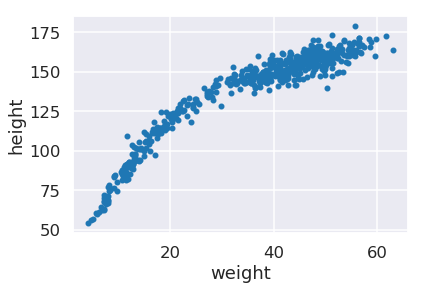

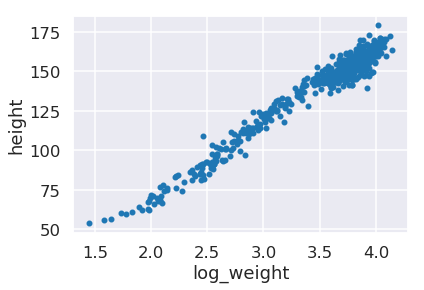

In [15]:
# Once again, take a look at what the data looks like
df.plot('weight', 'height', kind='scatter')
plt.show()

# And, define a log_weight column
df['log_weight'] = df.weight.apply(np.log)

# Then, plot height vs log weight
df.plot('log_weight', 'height', kind='scatter')
plt.show()

From the log weight plot, it looks like the height vs log_weight relationship is pretty much linear, after log_weight = 2 (so, roughly $e^{2}$ kg).  Although we can just model it as a linear function, as an exercise, let's try modelling this with a B-spline with 3 knots -- one at the beginning of the data, one at log_weight = 2, and one at the end of the data.

In [16]:
# Before we do anything else, let's sort our data by log_weight
df.sort_values('log_weight', inplace=True)

# First, need to specify our knots
knots = [df.log_weight.min(), 2, df.log_weight.max()]
#knots = np.quantile(df.log_weight, np.linspace(0, 1, num=3))

# Then, specify the B-matrix
B = patsy.dmatrix("bs(log_weight, knots=knots, degree=1, include_intercept=True)",
                   data={'log_weight': df.log_weight.values,
                         'knots': knots[1:-1]})
B.shape

(544, 4)

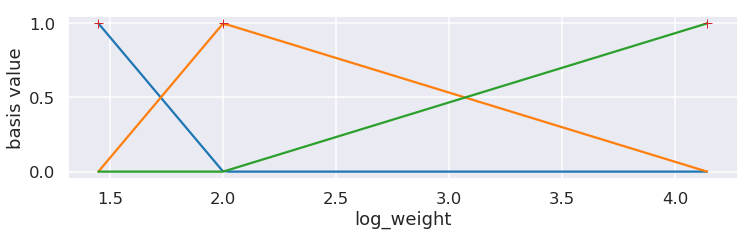

In [17]:
# Plot each of the lines
plt.figure(figsize=(12,3))
for i in range(1, B.shape[1]):
    plt.plot(df.log_weight, B[:, i])
plt.plot(knots, [1 for x in knots], '+')
plt.xlabel('log_weight')
plt.ylabel('basis value')
plt.show()

The above looks like what we'd expect for these basis funcitons.  Let's now build our model.

In [18]:
# Set the seed for reproducibility
np.random.seed(123)
with pm.Model() as height_mdl_2:
    # Originally, I followed the form from the book, but found this didn't model the data well,
    # since the majority of the predicted height value came from "a" and not much adjustment allowed
    # for the basis function weights.  So, I increased the variance allowed for the weights
    # to match our intercept, and now, I get much more reasonable predictions.
    
    a = pm.Normal('a', mu=178, sd=20)
    #ws = pm.Normal('w', mu=0, sd=1, shape=B.shape[1])
    ws = pm.Normal('w', mu=0, sd=20, shape=B.shape[1])

    mu = pm.Deterministic('mu', a + pm.math.dot(np.asarray(B), ws.T))
    sigma = pm.Exponential('sigma', 1)
    
    height = pm.Normal('height', mu, sigma, observed=df.height)
    trace_2 = pm.sample(draws=1000, tune=1000, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, w, a]
100%|██████████| 2000/2000 [01:57<00:00, 17.02it/s]


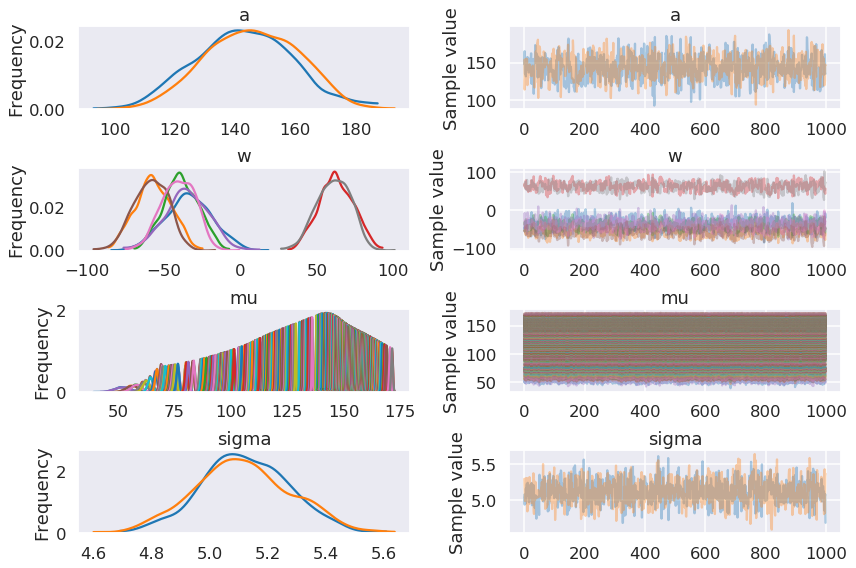

In [19]:
# Just to look at the traces
pm.traceplot(trace_2)
plt.show()

In [20]:
# Now, let's grab our posterior predictions
post = pm.trace_to_dataframe(trace_2)
post.head()

,a,w__0,w__1,w__2,w__3,mu__0,mu__1,mu__2,mu__3,mu__4,...,mu__535,mu__536,mu__537,mu__538,mu__539,mu__540,mu__541,mu__542,mu__543,sigma
0,147.861064,-45.195124,-52.852167,-31.471340,68.158226,49.813772,54.884250,57.296779,60.946374,62.464121,...,166.231779,166.622746,167.349882,167.462477,167.642063,168.220973,168.375610,169.936999,170.824165,5.079754
1,165.096282,-55.206436,-54.575175,-38.582818,61.143483,55.314670,59.107269,60.911784,63.641595,64.776835,...,166.436483,166.827830,167.555672,167.668376,167.848137,168.427609,168.582395,170.145301,171.033328,4.942206
2,135.486406,-33.417022,-53.642112,-31.778688,68.832874,48.427271,53.612197,56.079180,59.811153,61.363158,...,166.264606,166.659427,167.393730,167.507435,167.688791,168.273407,168.429568,170.006347,170.902257,5.052163
3,135.621789,-32.098849,-51.378328,-32.800639,67.746227,52.144613,56.550324,58.646558,61.817673,63.136435,...,166.634499,167.029066,167.762897,167.876528,168.057768,168.642008,168.798068,170.373833,171.269168,5.014396
4,142.582792,-28.677865,-62.831180,-44.710932,57.616526,51.073748,55.370977,57.415595,60.508626,61.794917,...,166.804709,167.206264,167.953090,168.068734,168.253183,168.847770,169.006594,170.610264,171.521454,4.954002


100%|██████████| 2000/2000 [00:01<00:00, 1030.50it/s]


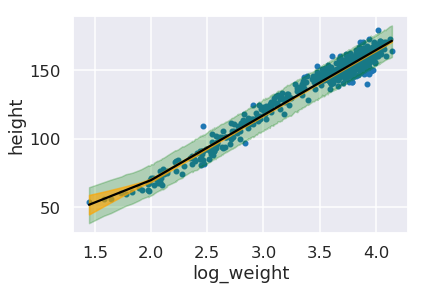

In [21]:
# Let's plot the data, and the predictions from the model
df.plot('log_weight', 'height', kind='scatter')

# Grab the posterior predicted heights
post_pred = pm.sample_posterior_predictive(trace_2, model=height_mdl_2)
# And the 97th percentile interval
post_pred_PI = np.percentile(post_pred['height'], [1.5, 98.5], axis=0)
plt.fill_between(df.log_weight, post_pred_PI[0], post_pred_PI[1], alpha=0.25, color='green')

# Grab the mu's for each log_weight
mus = post.loc[:, 'mu__0':f'mu__{B.shape[0] -1}']
mu = mus.mean(axis=0)
plt.plot(df.log_weight, mu, color='black')

# And find the 97th percentile interval
mu_PI = np.percentile(mus.values, [1.5, 98.5], axis=0)
plt.fill_between(df.log_weight, mu_PI[0], mu_PI[1], alpha=0.65, color='orange')

plt.show()

Our posterior prediction of height (in green) for the 97th percentile interval covers most of the data, with a few points falling outside, as expected.

-----

### Comparison with the solutions
In the solutions, as expected, he modeled with a linear function.  As this is relatively straightforward (using the same methods as from problem 1), I'll forgo trying to recreate it.

Also in the solutions is an interesting derivation of if you model a person as a cylinder, and the functional form of weight vs height that comes out.  We see that it fits the data fairly well!

## Problem 3
Plot the prior predictive distribution for the polynomial regression model in Chapter 4. You can modify the the code that plots the linear regression prior predictive distribution. 20 or 30 parabolas from the prior should suffice to show where the prior probability resides. Can you modify the prior distributions of $\alpha$, $\beta_1$ , and $\beta_2$ so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data.

-----
From the above, he talks about parabolas, so let's focus on the prior predictive distribution of the quadratic model.

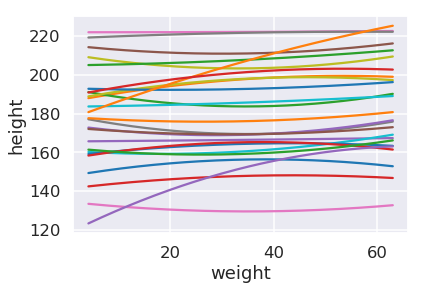

In [22]:
# First, set the number of lines we wish to model
N = 25

# Grab the weights for future use
weights = df.weight.values

# And, standardize them
std_weights = (weights - weights.mean()) / weights.std()

# Now, randomly sample from the priors
np.random.seed(123) # to get the same results every time
a = sps.norm.rvs(loc=178, scale=20, size=(1,N))
b_1 = sps.lognorm.rvs(1, loc=0, size=(1,N))
b_2 = sps.norm.rvs(loc=0, scale=1, size=(1,N))

mu = a + b_1 * std_weights.reshape(-1,1) + b_2 * (std_weights**2).reshape(-1,1)

# Now, plot these
plt.plot(weights, mu)
plt.xlabel('weight')
plt.ylabel('height')
plt.show()

This is actually not too bad, although the book noted that the world's tallest person is 272 cm, and obviously the size of an embryo has a limit of 0 cm, so this prior may be too infromative (pushing our predictions to be centered around 175 cm).  One major problem, though, is most of our curves say there is no real correlation between height and weight.  Let's try to fix this (perhaps less informative, but still in the realm of reason, with a positive correlation between weight and height).

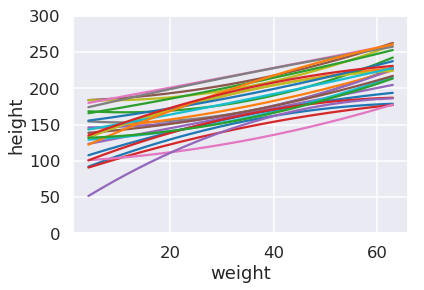

In [23]:
# Try different parameters on our priors
# Now, randomly sample from the priors
np.random.seed(123) # to get the same results every time
a = sps.norm.rvs(loc=178, scale=20, size=(1,N))
b_1 = sps.lognorm.rvs(1.1, loc=20, size=(1,N))
b_2 = sps.norm.rvs(loc=0, scale=3.5, size=(1,N))

mu = a + b_1 * std_weights.reshape(-1,1) + b_2 * (std_weights**2).reshape(-1,1)

# Now, plot these
plt.plot(weights, mu)
plt.xlabel('weight')
plt.ylabel('height')
plt.ylim(0, 300)
plt.show()

Overall, not bad!  Our new prior predictions are within the realm of reason for a height (between 0 and 272 cm), and also have a positive correlation between weight and height.

----

### Comparison with the solutions
In the solutions, we note that he tries to work with the curvature of the predictions more than the slope, and then gives an example of what a flat prior would give -- of particular note, that flat priors give explosive growth or shrinkage near the mean.  To quote:

```This is a general phenomenon with “flat” priors: Once the predictor is at all complicated, “flat” does not imply “no relationship.”```


Since there is no real target of how exactly we want our prior predictions to look (only that it do better than our original priors), I will leave what I have as sufficient.